# Валидация данных

Итак, существуют три основных вида выборок, которые используются в машинном обучении:

> 1. **Обучающая (тренировочная)** — набор данных, который используется в процессе обучения модели (подбора внутренних параметров, например коэффициентов линейной регрессии или предикатов в деревьях решений).

> 2. **Валидационная (проверочная)** — набор данных, на котором мы оцениваем промежуточные результаты обучения.

Основная цель создания такого набора данных — отслеживание переобучения.

На валидационной выборке мы производим подбор гиперпараметров — внешних параметров модели, например коэффициентов регуляризации, максимальной глубины дерева, количества деревьев в случайном лесу и т. д.

> 3. **Тестовая (контрольная)** — набор данных, который имитирует работу модели в реальных условиях после подбора всех параметров.

С помощью этого набора осуществляется окончательная проверка качества.

Главное условие для тестовой выборки — она должна быть независимой от обучающей.

___ 

Процесс проверки предсказательной способности модели машинного обучения называется **валидацией.**

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

In [2]:
water_data = pd.read_csv('data/water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
# информация о пропусках
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

Заполним пропуски медианным значением в признаке зависимости класса воды (Potability). Для этого сгруппируем данные по признаку Potability, посчитаем медиану в каждой группе, а затем отправим результат в метод fillna():

In [4]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

In [5]:
display(water_data.isnull().mean() * 100)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

In [6]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

### **Метод hold-out (отложенная выборка)**

**Метод hold-out (отложенная выборка)** нам уже знаком. Это самый простой и очень популярный метод.

Обычно разбиение производится в соотношении 70/30 или 80/20 при двухкомпонентном подходе, и в соотношении 70/15/15 или 80/10/10 — при трёхкомпонентном.

Метод hold-out реализован в уже знакомой вам функции train_test_split(). Она предназначена для разбиения исходного набора данных случайным образом на две части в заданных соотношениях.

Основные параметры train_test_split():

- *arrays — порядковый аргумент с переменным количеством. Набор массивов (это могут быть списки, numpy-массивы, DataFrame), которые подлежат разбиению.
- test_size — размер тестовой (валидационной) выборки. Может быть указан в долях. Определяется автоматически, если параметр test_size передан как 1-train_size.
- train_size — размер тренировочной выборки. Может быть указан в долях. Определяется автоматически, если параметр test_size передан как 1-test_size.
- random_state — число, на основе которого производится генерация случайных чисел.
- shuffle — параметр, указывающий, стоит ли перемешивать выборку перед разбиением (по умолчанию True).
- stratify — стратифицированное разбиение (о нём мы поговорим в юните по дисбалансу выборки).

___

Если мы используем двухкомпонентный подход (разбиваем выборку на тренировочную и валидационную, она же тестовая), то всё очень просто: нам лишь нужно вызвать функцию train_test_split() и передать в неё матрицу наблюдений X и вектор-столбец с правильными ответами y.

Для примера разделим выборку в соотношении 80/20 (test_size=0.2), в качестве значения параметра random_state по традиции возьмём число 42.

Функция вернёт четыре массива:

- таблицу X с обучающими примерами,
- таблицу X с примерами для валидации,
- столбец y с ответами на обучающие примеры,
- столбец y с ответами на валидационные примеры.

In [7]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (2620, 9)
Valid shape: (656, 9)


В качестве модели будем использовать дерево решений с максимальной глубиной 7, энтропией в качестве критерия информативности, минимальное число объектов в листе дерева — 5.

После обучения сделаем предсказание для каждой из выборок и рассчитаем метрику. В качестве метрики для простоты возьмём долю правильных ответов — accuracy.

In [9]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred))) 

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


Если же мы используем трёхкомпонентный подход (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), нам понадобится чуть больше кода. К сожалению, в sklearn нет специализированного функционала для такого разбиения.

Применим функцию train_test_split() дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении 80/20, затем разобьём валидационный набор на валидационный и тестовый в соотношении 50/50. В итоге наша выборка будет разбита в соотношении 80/10/10:

In [10]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

In [11]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


В этом случае мы будем обучаться на 2620 примерах, 328 будем использовать для промежуточного контроля и подбора внешних параметров и ещё 328 будут нашим контрольным рубежом — их мы будем использовать для принятия финального решения о качестве модели.

### **k-fold кросс-валидация (cross validation)**

Метод k-fold более известен как **кросс-валидация (cross validation)**, или перекрёстный контроль.

Напомним алгоритм кросс-валидации:

1. Разбить исходную выборку на k частей — *фолдов (fold)*.
2. Повторять k раз:
* Обучить модель на (k-1) частях. Назовём их **тренировочными фолдами (training fold)**. 
Произвести оценку качества (вычислить метрику) на оставшейся части. Назовем её **валидационным фолдом (validation fold)**.
3. Усреднить значения метрики на валидационных фолдах.


___


Благодаря такому подходу мы избавляемся от необходимости создавать отложенную валидационную выборку — мы генерируем её искусственно на каждом из этапов кросс-валидации из исходного набора данных. Каждая из  частей исходного обучающего набора данных используется в качестве валидационной выборки.

Для больших наборов данных в качестве значения  часто берут 10, то есть выборка разбивается на десять фолдов. В случае маленьких выборок  берут равным 3 или 5.

→ Чем больше , тем больше моделей будут обучаться, тем объективнее будет оценка качества, однако тем больше времени займёт процесс валидации.

В библиотеке sklearn метод k-fold реализован в классе KFold.

Основные параметры инициализатора KFold:

- n_split — число фолдов (число  из метода k-fold). По умолчанию — 5.
- shuffle — параметр, указывающий, стоит ли перемешивать исходный набор данных перед разбиением. По умолчанию — False.
- random_state — число, на основе которого производится генерация случайных чисел, если набор данных будет перемешиваться.

У объекта класса KFold есть метод split(). В данный метод необходимо передать матрицу наблюдений X и вектор-столбец ответов y — метод вернёт генератор, который позволит получать индексы тренировочной и валидационной выборок, сгенерированных по методу k-fold.

Будем использовать двухкомпонентный контроль, то есть подавать в кросс-валидацию весь доступный набор данных без предварительного выделения тестовой выборки.

Создадим объект KFold для кросс-валидации с пятью фолдами, остальные параметры оставим по умолчанию. Затем организуем цикл for для получения элементов из генератора, созданного с помощью метода split(). На каждой итерации в переменных train_index и valid_index будут находиться индексы текущей тренировочной и валидационной выборок соответственно.

В цикле будем:

1. выделять строки таблицы, относящиеся к текущим тренировочной и валидационной выборкам, в отдельные таблицы;
2. обучать дерево решений;
3. делать предсказания для текущих тренировочной и валидационной выборок;
4. рассчитывать метрику accuracy на текущих выборках и заносить её значение в список.

Код будет выглядеть следующим образом:

In [12]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем случайный лес на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

In [13]:
print(train_metrics)
print(val_metrics)

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


In [14]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


На самом деле весь приведённый выше код можно значительно сократить, если использовать специальную функцию для кросс-валидации — cross_validate() из модуля model_selection. Она организует процедуру кросс-валидации и расчёт метрик.

Основные параметры функции cross_validate():

* estimator — модель, качество которой будет проверяться на кросс-валидации.
* X — матрица наблюдений.
* y — вектор-столбец правильных ответов.
* cv — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.
* scoring — название метрики в виде строки либо функция для её вычисления ('accuracy', 'precision', 'recall', 'f1' и другие; полный список — в документации к функции).
* return_train_score — параметр, указывающий стоит ли возвращать значения метрики, полученные на тренировочных фолдах. По умолчанию — False, то есть метрики считаются только на валидационных фолдах.


Функция возвращает словарь со следующими ключами:

- fit_time — время обучения модели на каждой итерации кросс-валидации;
- score_time — время вычисления метрик на каждой итерации кросс-валидации;
- test_score — значения метрик на валидационных фолдах;
- train_score — значения метрик на тренировочных фолдах.


Итоговый код с использованием функции cross_validate() будет выглядеть следующим образом:

In [15]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.03442192, 0.03269529, 0.03559041, 0.03312469, 0.04505944]),
 'score_time': array([0.00300288, 0.        , 0.        , 0.        , 0.        ]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

In [16]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


### **leave-one-out (отложенный пример), или поэлементная кросс-валидация**

Метод **leave-one-out (отложенный пример)**, или поэлементная кросс-валидация — это частный случай кросс-валидации (k-fold), когда размер k равняется размеру всей выборки k=n, где n — количество примеров (строк в таблице).

Алгоритм метода:

1. Повторять n раз:
* Выбрать один случайный пример для валидации.
* Обучить модель на всех оставшихся n примерах.
* Произвести оценку качества (вычислить метрику) на отложенном примере.
2. Усреднить значение метрик на всех примерах.

В библиотеке sklearn метод leave-one-out реализован в классе LeaveOneOut. Параметров инициализации у данного класса нет.

Работа с кросс-валидатором полностью идентична работе с KFold, который мы рассматривали ранее (цикл для организации кросс-валидации вручную будет выглядеть аналогично).

Объект класса LeaveOneOut также можно передать в функцию cross_validate() для получения метрик на каждом из примеров. В случае с метрикой accuracy список будет состоять из 0 и 1 (0 — модель не угадала класс на отложенном примере, 1 — модель угадала класс на отложенном примере).

Так как датасет у нас довольно большой (более трёх тысяч образцов воды), алгоритм кросс-валидации leave-one-out будет выполняться очень долго. Для экономии времени выполнения кода будем использовать первые 500 наблюдений из исходной таблицы.

Примечание. Значение метрики будет рассчитано не для всего набора данных, а только для его части. Если вы захотите рассчитать метрику на всём наборе данных, вместо среза передавайте в функцию таблицу X и столбец y целиком. Но имейте в виду, что код в таком случае может выполняться до нескольких минут.

In [17]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X
    y=y.iloc[:500], #вектор ответов y
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
 
## Train k-fold mean accuracy: 0.95
## Valid k-fold mean accuracy: 0.90

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


**Примечание.** Метод leave-one-out можно реализовать и без использования специального класса — достаточно просто указать параметр n_split=n в инициализаторе KFold, где n — количество строк в таблице.

# Дисбаланс выборки

**Несбалансированный набор данных (unbalanced dataset)** — это выборка, в которой количества примеров каждого из классов значительно отличаются.

При этом:

* класс большинства называется **мажоритарным (majority) классом;**
* класс меньшинства называется **миноритарным (minority) классом.**

0    0.60989
1    0.39011
Name: Potability, dtype: float64

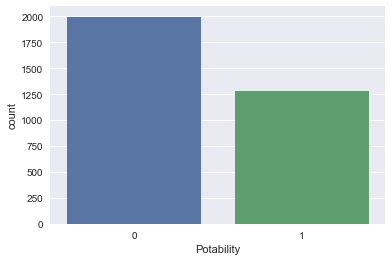

In [18]:
display(water_data['Potability'].value_counts(normalize=True))
sns.countplot(data=water_data, x='Potability');

Рассмотрим особенности разбиения выборок в условиях дисбаланса классов.

## СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ

Для того чтобы снизить влияние дисбаланса классов при разбиении выборки, в наборе данных используется специальный тип разбиения, который называется **стратифицированным (stratified)**. Данное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции.

Давайте на примере рассмотрим, как производить стратифицированное разбиение. Начнём с простого разделения hold-out, которое мы проводим с помощью функции train_test_split(). Для начала проведём обычное случайное разбиение на тренировочную и валидационную выборку (в соотношении 80/20) без стратификации:

In [19]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.620229
1    0.379771
Name: Potability, dtype: float64
Valid:
0    0.568598
1    0.431402
Name: Potability, dtype: float64


Для стратифицированного разбиения достаточно в функции train_test_split() задать параметр stratify, в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец с правильными ответами y.

In [20]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Valid:
0    0.609756
1    0.390244
Name: Potability, dtype: float64


**А что насчёт кросс-валидации? Как организовать разбиение по методу k-fold и получить одинаковые соотношения классов?**

Для этого вместо KFold используется кросс-валидатор StratifiedKFold. Принцип работы с ним аналогичен, только, в отличие от KFold, StratifiedKFold будет разбивать выборку на части таким образом, чтобы в тренировочных и валидационных фолдах соотношения классов были приблизительно одинаковыми.

Давайте напишем код, который организует стратифицированное k-fold-разбиение на три фолда, и выведем соотношения классов в каждой из выборок:

In [21]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


## ВЫБОР МЕТРИК В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

Мы поговорили о том, как производить разбиение в условиях дисбаланса классов. Следующий пункт в нашем списке проблем — это использование метрик, которые плохо работают с дисбалансом.

Основной представитель таких метрик — это знакомая нам accuracy, доля угаданных моделью ответов

Загвоздка заключается в том, что данная метрика абсолютно не отражает предсказательную способность модели в отношении каждого из классов. В условиях дисбаланса классов данная метрика может дать ложные представления о качестве модели.

___
Давайте на примере посмотрим, насколько важен выбор метрики в случае дисбаланса выборки.

Разобьём выборку на тренировочную и валидационную в соотношении 80/20, используя стратифицированное разбиение, затем обучим модель дерева решений, сделаем предсказание для каждой из выборок и сформируем отчёт о метриках на валидационной выборке с помощью функции classification_report().

In [22]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.65       256

    accuracy                           0.77       656
   macro avg       0.78      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656



## ПОСТРОЕНИЕ МОДЕЛИ В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

Существует несколько способов уменьшить влияние дисбаланса на обучение модели:

1. Взвешивание объектов. В функцию ошибки добавляется штраф, прямо пропорциональный количеству объектов каждого класса. Это очень похоже на регуляризацию, которую мы изучали ранее.
2. Выбор порога вероятности. Этот подход мы с вами тоже уже использовали ранее. Он заключается в том, что мы подбираем такой порог вероятности (по умолчанию он равен 0.5 во всех моделях), при котором на валидационной выборке максимизируется целевая метрика (например, -score).
3. Сэмплирование (sampling) — перебалансировка выборки искусственным путём:
* oversampling — искусственное увеличение количества объектов миноритарного класса;
* undersampling — сокращение количества объектов мажоритарного класса.

Здесь могут использоваться алгоритмы генерации искусственных данных, такие как NearMiss, SMOTE (Synthetic Minority Oversampling Techniques) и ADASYN (Adaptive Synthetic).


### ВЗВЕШИВАНИЕ ОБЪЕКТОВ

Большинство моделей, реализованных в sklearn, имеют параметр class_weight — веса классов.

Для того чтобы задать веса классам по приведённым выше формулам, достаточно в инициализаторе модели выставить параметр class_weight='balanced'.

In [23]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       400
           1       0.63      0.76      0.69       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



### ВЫБОР ПОРОГА ВЕРОЯТНОСТИ. PR-КРИВАЯ

Следующий метод, о котором мы поговорим, — это выбор порога вероятности (бинаризации).

**PR-кривая (precision-recall curve)** — это график зависимости precision от recall при различных значениях порога вероятности.

Во-первых, PR-кривая — это графическая метрика качества модели, она комплексно отражает и precision, и recall одновременно (как F1 -мера) и особенно хороша в условиях дисбаланса классов.

Качество определяется площадью (PR AUC) под кривой: чем ближе значение площади к 1, тем лучше модель. Идеальная модель — та, у которой площадь равна 1. У такой модели и precision, и recall равны 1. Конечно же, таких моделей не существует в природе.

Если площадь под PR-кривой меньше 0.5, модель считается очень слабой (качество её распознавания хуже, чем подбрасывание монетки).

Во-вторых, с помощью PR-кривой удобно находить оптимальный порог вероятности. Главное — определиться с критерием этой оптимальности. На кривой мы можем найти такие точки, в которых наблюдается наилучшее значение precision или recall или среднее геометрическое между ними (F1-score). 

___

Подберём порог вероятности с помощью PR-кривой для нашего примера. Так как порог вероятности является внешним параметром модели, будет правильнее подбирать его на кросс-валидации, организованной на тренировочном наборе данных, а итоговое качество оценивать на отложенной выборке.

Перед построением PR-кривой нам необходимо предсказать вероятность принадлежности к классу 1 на валидационных фолдах кросс-валидации.

Для предсказания вероятностей используем функцию cross_val_predict(). Данная функция выполняет кросс-валидацию и возвращает предсказания для валидационных фолдов. Если ей передать параметр method='predict_proba', она вернёт предсказанные вероятности для каждого из классов на всех фолдах. Остальные параметры аналогичны параметрам функции cross_validate().

In [24]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')

In [25]:
y_cv_proba_pred

array([[0.        , 1.        ],
       [0.24561404, 0.75438596],
       [1.        , 0.        ],
       ...,
       [0.60621762, 0.39378238],
       [1.        , 0.        ],
       [0.03030303, 0.96969697]])

Это массив из вероятностей для каждого образца воды. Первое число в строке — вероятность того, что данный образец является непригодным для питья, а второе — вероятность того, что данный образец пригоден для питья.

Нас интересует класс 1 (пригодная для питья вода). Это второй столбец в матрице вероятностей (индекс 1). Выделим этот столбец из матрицы с вероятностями:

In [26]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

Теперь мы можем построить PR-кривую. Для этого воспользуемся функций precision_recall_curve() из модуля metrics библиотеки sklearn. В данную функцию нужно передать истинные метки классов и предсказанные вероятности. Взамен она вернёт три массива: значения метрик precision и recall, вычисленных на различных порогах вероятности, и сами пороги вероятности:

In [27]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.02739726 0.02898551 0.05       0.07407407]
Precision scores: [0.39007634 0.50050659 0.50357873 0.50437919 0.5043837 ]
Recall scores: [1.         0.9667319  0.96379648 0.95792564 0.95694716]


Осталось дело за малым. Вычислим значение F1-score при различных порогах вероятности и найдём такой порог вероятности, при котором она максимальна. Сделать это можно с помощью функции argmax() из модуля numpy — она возвращает индекс максимального элемента массива.

Далее построим PR-кривую и отметим на ней точку максимума F1-score.

Best threshold = 0.33, F1-Score = 0.69


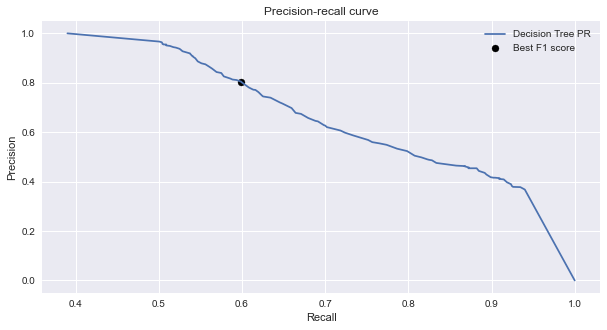

In [28]:
#Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')
#Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

Итак, согласно нашим вычислениям и построенной PR-кривой, максимум F1 (0.69) на кросс-валидации наблюдается при пороге вероятности 0.33.

Сделаем предсказание классов с таким порогом для всех объектов из отложенной валидационной выборки и выведем отчёт о метриках:

In [29]:
threshold_opt=0.33

In [30]:
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       400
           1       0.62      0.76      0.68       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



Итак, при применении метода подбора вероятности увеличилось значение метрик recall и  для класса 1. Нам удалось сократить разницу метрик между классами и заставить модель практически одинаково хорошо предсказывать классы питьевой и непитьевой воды.

**Примечание.** Чтобы вычислить площадь под PR-кривой, используется функция auc() из модуля metrics библиотеки sklearn. В данную функцию нужно передать значения метрик recall и precision при различных порогах вероятности:

In [31]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))
# PR AUC: 0.79

PR AUC: 0.79


### СЭМПЛИРОВАНИЕ

Следующий подход работы в условиях дисбаланса классов, который мы рассмотрим, — сэмплирование, а точнее — **пересэмплирование (oversampling)**.

Идея очень проста: если у нас мало наблюдений миноритарного класса, следует искусственно увеличить их количество.

Простейшая стратегия пересэмплирования — продублировать объекты малого класса. Но это неинтересно и работает довольно плохо. Поэтому были созданы специальные алгоритмы генерации искусственных данных. Самый популярный из таких алгоритмов — **алгоритм SMOTE (Synthetic Minority Oversampling Techniques).**

В основе алгоритма лежит идея генерации некоторого количества искусственных наблюдений, которые были бы «похожи» на наблюдения, имеющиеся в миноритарном классе, но при этом не дублировали их.

Все алгоритмы пересэмплирования находятся в модуле over_sampling библиотеки imblearn. Импортируем оттуда алгоритм SMOTE:

In [32]:
from imblearn.over_sampling import SMOTE

Создадим объект класса SMOTE и вызовем у него метод fit_sample(), передав в него обучающую выборку (X_train, y_train). Затем выведем количество наблюдений каждого из классов до и после сэмплирования:

In [33]:
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (2620, 9)
Class balance before oversampling: 
0    1598
1    1022
Name: Potability, dtype: int64
----------------------------------------
Train shape after oversampling: (3196, 9)
Class balance after oversampling: 
0    1598
1    1598
Name: Potability, dtype: int64


In [34]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       400
           1       0.63      0.78      0.69       256

    accuracy                           0.73       656
   macro avg       0.73      0.74      0.73       656
weighted avg       0.75      0.73      0.73       656



# НЕДООБУЧЕНИЕ И ПЕРЕОБУЧЕНИЕ. УТЕЧКА ДАННЫХ

Переобучение (overfitting) — это проблема, при которой модель чувствительна к незначительным колебаниям в данных в процессе обучения. По сути, такая модель работает намного лучше с обучающими данными, чем с новыми. Она была чрезмерно натренирована на обнаружение уникальных характеристик обучающего набора данных, которые не являются общими закономерностями.

Недообучение (underfitting) — это проблема, при которой алгоритм недостаточно хорошо изучил данные и пропускает важные зависимости между признаками. В случае недообучения мы даже на обучающих данных не можем достичь приемлемых оценок для модели.

Недообучение и переобучение неразрывно связаны друг с другом: попытка бороться с одной проблемой может привести к возникновению другой, поэтому возникает дилемма смещения-разброса (bias-variance tradeoff). 

Смещение (bias) — это математическое ожидание (обозначено далее как E) разности между истинным ответом и ответом, выданным моделью. То есть это ожидаемая ошибка модели.

Разброс (variance) — это вариативность ошибки, то, насколько ошибка будет отличаться, если обучать модель на разных наборах данных. Математически это дисперсия (разброс) ответов модели (обозначено далее как Var).

___

Проблема заключается в том, что в реальных условиях построить визуализацию модели, подобную приведённым выше, невозможно из-за размерности данных (если только мы не применим методы понижения размерности). Поэтому нужно уметь обнаруживать недообучение и переобучение другими способами.

Если с недообучением всё понятно (измеряем метрику на тренировочной выборке и, если она нас не устраивает, делаем вывод, что модель недообучена), то с переобучением всё несколько сложнее. Переобучение является наиболее популярной проблемой, поэтому её необходимо уметь обнаруживать.

## Как обнаружить переобучение

Переобучение легко детектируется с помощью изученных нами методов валидации: мы намеренно разбиваем выборку на тренировочную и валидационную (возможно, и тестовую) и смотрим на значения показателей на каждой из выборок, сравнивая их между собой.

Основные способы отследить переобучение:

- hold-out-разбиение,
- k-fold-валидация и leave-one-out-валидация,
- кривые обучения (learning curves).
___

Если качество на валидационной выборке стабильно хуже качества на тренировочной, то это явный признак переобучения.

Рассмотрим пример. Будем использовать тот же набор данных об образцах воды.

Сначала проверим модель на переобучение с помощью отложенной (hold-out) выборки.

Для этого стратифицированно разобьём набор данных на тренировочную и валидационную выборки в соотношении 80/20 и обучим дерево решений с энтропией  в качестве критерия информативности и сбалансированными весами классов без ограничения его глубины и количества объектов в листе. Сделаем предсказание для каждой из выборок и рассчитаем метрику F1-score:

In [35]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    class_weight='balanced', #веса классов
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid F1 score: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))

Train F1 score: 1.00
Valid F1 score: 0.67


* Значение F1-score на тренировочной выборке показывает, что задача классификации образцов воды на пригодные и непригодные для питья решена идеально. Метрика равна максимуму — 1, а значит, и precision и recall для каждого из классов равны 1 (значит, и значения всех остальных метрик тоже максимальны). То есть модель правильно определила класс для всех образцов воды из набора данных.
* Однако значение F1-score, полученное на валидационной выборке, менее оптимистично. Значение метрики на контроле значительно ниже, чем при обучении.

Проверим гипотезу о наличии переобучения у нашего дерева с помощью кросс-валидации k-fold. Организуем стратифицированную кросс-валидацию на пяти фолдах. На каждом шаге кросс-валидации будем вычислять метрику F1 на тренировочных и валидационных фолдах.

In [36]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model_bad, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.03503942, 0.03418851, 0.03899145, 0.03749537, 0.0322237 ]),
 'score_time': array([0.        , 0.00213718, 0.00099969, 0.00251293, 0.        ]),
 'test_score': array([0.61445783, 0.68421053, 0.62332696, 0.63276836, 0.70119522]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [37]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


### МЕТОДЫ БОРЬБЫ С ПЕРЕОБУЧЕНИЕМ

1. УМЕНЬШЕНИЕ СЛОЖНОСТИ МОДЕЛИ

Это основной способ борьбы с переобучением, так как, по сути, повышенная сложность модели и является его причиной.

Рекомендации по уменьшению сложности моделей
Для линейной (логистической) регрессии с полиномиальными признаками уменьшение сложности модели означает понижение степени полинома.

Для деревьев решений — «стрижка» (pruning) деревьев, то есть уменьшение их глубины (max_depth) и/или увеличение количества объектов, при которых вершина дерева превращается в лист (min_samples_leaf).

Для случайного леса — «стрижка» деревьев (max_depth и min_samples_leaf) и уменьшение количества признаков, на которых обучается каждое дерево (max_features).

2. РЕГУЛЯРИЗАЦИЯ

С помощью добавления штрафа в функцию потерь мы намеренно пытаемся увеличить смещение модели, чтобы уменьшить разброс. Закон баланса в действии!

Ранее мы изучали регуляризацию только в контексте линейных моделей, но на самом деле она есть и во многих других методах машинного обучения, с которыми мы будем знакомиться в дальнейшем.

3. МАНИПУЛЯЦИИ С ДАННЫМИ

Ещё один верный способ побороть переобучение — увеличить или уменьшить количество примеров, на которых обучается модель.

* Увеличивать набор данных можно за счёт проведения новых экспериментов и сбора новой информации.
* Уменьшать набор данных можно за счёт удаления выбросов и аномалий из обучающего набора данных, из-за которых отчасти и происходит переобучение модели.

Также можно отбирать наиболее значимые признаки, которые в наибольшей степени влияют на предсказания модели.

In [38]:
print('Current depth:', model_bad.get_depth())

Current depth: 27


Дерево глубиной 27 — это очень сложная модель. Давайте попробуем её упростить, добавив в дерево решений ограничение на глубину (max_depth). Пусть максимальная глубина дерева будет равна 7.

In [39]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.75
Valid k-fold mean f1: 0.66


Попробуем добавить ещё одно ограничение к нашему дереву: увеличим количество объектов, которых достаточно для образования листа дерева (min_samples_leaf). По умолчанию этот параметр равен 1. 

Напомним интерпретацию данного параметра. Пусть min_samples_leaf=5. Допустим, в результате разделения получается две вершины: первая — с четырьмя объектами, а вторая — с шестью. Тогда дерево разрешит снова делиться только второй вершине (6 > min_samples_leaf), а первая вершина (4 < min_samples_leaf) дерева превратится в лист, и её деление будет остановлено.

In [40]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    min_samples_leaf=5, #увеличиваем количество объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.74
Valid k-fold mean f1: 0.66


## УТЕЧКА ДАННЫХ

**Утечка данных (data leak**) — это ситуация, в которой данные, используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной.

Приведём несколько примеров, когда может возникнуть утечка данных:

1. ОЧЕВИДНЫЕ СЛУЧАИ

Наиболее очевидной ситуацией утечки данных является включение целевой переменной, которую мы пытаемся предсказать, в качестве фактора, что полностью уничтожает цель «прогнозирования». Это может быть сделано по ошибке, но важно убедиться, что целевая переменная отличается от признаков.

Другой распространённой причиной утечки данных является включение тестовых данных в данные по обучению модели, а затем использование этих же тестовых данных для оценки качества модели.

Два этих случая возникают скорее по невнимательности, и их легко обнаружить. Более опасные причины — скрытые.

2. СКРЫТЫЕ СЛУЧАИ, ИЛИ GIVEAWAY-ПРИЗНАКИ

Giveaway — это признаки, которые раскрывают информацию о целевой переменной и не будут доступны после развёртывания модели в реальных условиях. Такие признаки необходимо удалять из данных перед построением модели.

КАК ОБНАРУЖИТЬ УТЕЧКУ ДАННЫХ

* Читайте описание признаков.

Из описания признаков всегда можно узнать полезную информацию и обнаружить утечку с помощью банальной логики. Если вы предсказываете цену товара, а в вашем наборе данных есть признак цены этого товара со скидкой, очевидно, что данный признак стоит удалить из обучающего набора данных.

* Проверяйте корреляции с целевым признаком.

В процессе разведывательного анализа вы можете обнаружить признаки, которые очень сильно коррелируют с целевой переменной. Конечно, такая корреляция может быть естественной и не сопровождаться утечкой, например корреляция между количеством комнат в квартире и её ценой. Однако высокая степень корреляции между налоговой выплатой за продажу и ценой квартиры — это яркий пример утечки.

* Относитесь скептически к подозрительно высокому качеству моделей.

При построении модели вас может насторожить слишком высокое качество даже самых простых моделей, которого в реальных условиях достичь не удалось бы. Это может быть сигналом о наличии утечки данных.

Поэтому для начала старайтесь строить baseline — простые модели машинного обучения, такие как логистическая регрессия.

# **КРИВАЯ ОБУЧЕНИЯ**

В этом модуле мы поговорим о других графиках, называемых **кривыми обучения (learning curve)**. Они позволяют легко определять наличие переобучения и недообучения, визуально сравнивать модели собой и увидеть, как качество модели зависит от добавления новых данных.и

**Кривая обучения (learning curve)** — это график зависимости некоторой метрики на обучающем (валидационном) наборе данных от количества объектов, которые участвуют в обучении модели.

Основное назначение кривых обучения — **мониторинг изменения метрики в процессе поступления новых данных**. Благодаря этому мы можем найти такой размер данных, начиная с которого обогащение набора данных новыми наблюдениями не приносит значительного эффекта.

Благодаря кривым обучения мы можем **отслеживать недообучение и переобучение модели**.

Кривые обучения позволяют **визуально сравнить качество различных моделей**.

Для вычисления точек для построения кривых обучения в модуле model_selection библиотеки sklearn есть функция learning_curve().

Основные параметры функции learning_curve():

* estimator — модель, качество которой будет проверяться на кросс-валидации.
* X — матрица наблюдений.
* y — вектор-столбец правильных ответов.
* train_sizes — относительное (долевое) или абсолютное количество обучающих примеров, которые будут использоваться для создания кривой обучения. 
Если dtype имеет значение float, он рассматривается как часть максимального размера обучающего набора (который определяется выбранным методом проверки), т. е. он должен быть в пределах (0, 1].

По умолчанию используется список [0.1, 0.325, 0.55, 0.775, 1.0], то есть для построения кривой обучения используется пять точек. Первая точка кривой обучения строится по 10 % наблюдений из обучающего набора, вторая точка — по 32.5 % и так далее до тех пор, пока в построении модели не будет участвовать весь обучающий набор данных.

* cv — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация k-fold на пяти фолдах.
* scoring — название метрики в виде строки либо функция для её вычисления.

___
Если передать функции все необходимые параметры, она вернёт три массива:

* Список из размеров тренировочного набора (ось абсцисс кривой обучения).
* Матрица из метрик, полученных при разных размерах тренировочного набора во время кросс-валидации на тренировочных фолдах. В строках этой таблицы указаны списки метрик, соответствующие каждому размеру тренировочного набора данных, а внутри списков находятся сами метрики на кросс-валидации.
* Матрица из метрик, полученных при разных размерах тренировочного набора во время кросс-валидации на валидационных фолдах.

In [41]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    class_weight='balanced', 
    random_state=42, #генератор случайных чисел 
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Вычисляем координаты для построения кривой обучения
train_sizes, train_scores, valid_scores = model_selection.learning_curve(
    estimator = model, #модель
    X = X, #матрица наблюдений X
    y = y, #вектор ответов y
    cv = skf, #кросс-валидатор
    scoring = 'f1' #метрика
)
print('Train sizes: \n', train_sizes)
print('Train scores: \n', train_scores)
print('Valid scores: \n', valid_scores)

Train sizes: 
 [ 262  851 1441 2030 2620]
Train scores: 
 [[0.8        0.72727273 0.72727273 0.72727273 0.72727273]
 [0.76156584 0.82522523 0.8757764  0.8757764  0.8757764 ]
 [0.78546099 0.80108011 0.78497653 0.78183613 0.78183613]
 [0.75440806 0.74526573 0.72822528 0.76443265 0.75997384]
 [0.73336393 0.75992939 0.72322275 0.74051593 0.76085963]]
Valid scores: 
 [[0.62222222 0.2228739  0.18128655 0.25329815 0.28486647]
 [0.64528302 0.4978903  0.46031746 0.53831776 0.56928839]
 [0.59622642 0.60687023 0.60805861 0.56624319 0.60820896]
 [0.60903733 0.68641115 0.63859649 0.59344894 0.67407407]
 [0.61981982 0.6797153  0.66294227 0.61689587 0.71719039]]


Для того чтобы вычислить среднюю кросс-валидационную метрику на каждом из наборов данных, необходимо рассчитать среднее по столбцам матриц train_scores и valid_scores:

In [42]:
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
 
print('Train k-fold f1 scores',  train_scores_mean)
print('Valid k-fold f1 scores',  valid_scores_mean)
 
## Train k-fold f1 scores [0.74181818 0.84282405 0.78703798 0.75046111 0.74357833]
## Valid k-fold f1 scores [0.31290946 0.54221938 0.59712148 0.6403136  0.65931273]

Train k-fold f1 scores [0.74181818 0.84282405 0.78703798 0.75046111 0.74357833]
Valid k-fold f1 scores [0.31290946 0.54221938 0.59712148 0.6403136  0.65931273]


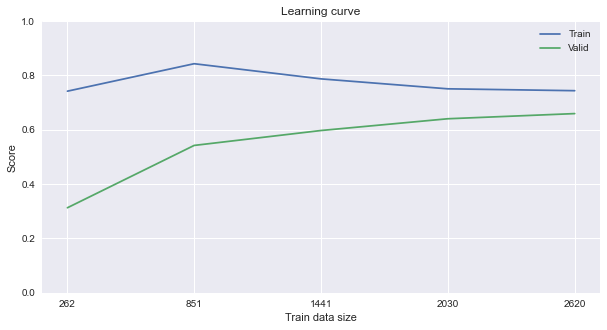

In [43]:
#Визуализируем кривую обучения
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим кривую обучения по метрикам на тренировочных фолдах
ax.plot(train_sizes, train_scores_mean, label='Train')
#Строим кривую обучения по метрикам на валидационных фолдах
ax.plot(train_sizes, valid_scores_mean, label='Valid')
#Даём название графику и подписи осям
ax.set_title('Learning curve')
ax.set_xlabel('Train data size')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси абсцисс
ax.xaxis.set_ticks(train_sizes)
#Устаналиваем диапазон оси ординат
ax.set_ylim(0, 1)
#Отображаем легенду
ax.legend();

In [44]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

In [45]:
#Создаём список из моделей
models = [
    linear_model.LogisticRegression(
        max_iter=1000, #количество итераций на сходимость
        random_state=42, #генератор случайных чисел
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        max_depth=7, #максимальная глубина
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
]

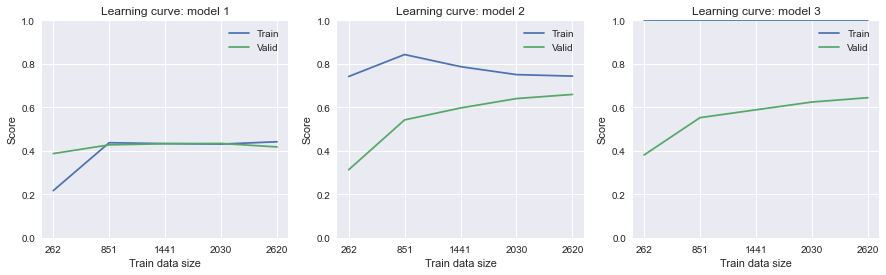

In [46]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + три координатных плоскости
#Создаём цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i — текущий индекс, model — текущая модель
    plot_learning_curve(model, X, y, skf, ax=axes[i], title=f'model {i+1}')